# Model validation water levels

Note: this notebook requires the model output data

In [1]:
import mikeio
import modelskill as ms
import matplotlib.pyplot as plt 
import helper as h

In [2]:
ms.options.metrics.list = ["rmse", "mae", "cc", "si", "r2"]

Instead of reading the entire dfsu (`Area.dfsu`), we can simply load the outputted points (dfs0) since they correspond to the locations we have observations from.

In [3]:
mr_fldr = "../output/"    
# mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
save_png = False if "sample" in mr_fldr else True
fig_fldr = "../figures/" 


Model results data are stored in a dfs0 file. We can use [MIKE IO](https://dhi.github.io/mikeio) read the data to a MIKE IO Dataset.

Note: The first two spin-up days are excluded.

In [4]:
ds = mikeio.read(f"{mr_fldr}Points.dfs0", items="*Surf*", time = slice("2014-01-03", None))
ds.items

[Drogden: Surface elevation <Surface Elevation> (meter),
 Klagshamn: Surface elevation <Surface Elevation> (meter),
 Barseback: Surface elevation <Surface Elevation> (meter),
 Dragor: Surface elevation <Surface Elevation> (meter),
 Flinten7: Surface elevation <Surface Elevation> (meter),
 Helsingborg: Surface elevation <Surface Elevation> (meter),
 Hornbaek: Surface elevation <Surface Elevation> (meter),
 Kobenhavn: Surface elevation <Surface Elevation> (meter),
 Koege: Surface elevation <Surface Elevation> (meter),
 MalmoHamn: Surface elevation <Surface Elevation> (meter),
 Skanor: Surface elevation <Surface Elevation> (meter),
 Vedbaek: Surface elevation <Surface Elevation> (meter),
 NordreRose: Surface elevation <Surface Elevation> (meter)]

## Compare to water level station observations

The [ModelSkill package](https://dhi.github.io/modelskill/) can be used to compare model results with observations.

In [5]:
wllist = h.get_wl_point_obs()

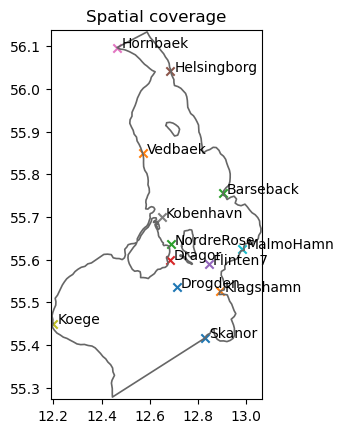

In [6]:
msh = mikeio.open("../input/mesh_EMOD.mesh")
ms.plotting.spatial_overview(wllist, mod=msh);

Match the right model result timeseries and observation. Also, remove the bias (different vertical datum).

In [7]:
cmps = []
for o in wllist:
    mr = ms.PointModelResult(ds[o.name+": Surface elevation"], name="MIKE21")
    try:
        cmp = ms.match(obs=o, mod=mr)
    except Exception as e:
        print(e)
    cmps.append(cmp.remove_bias())
cc = ms.ComparerCollection(cmps)

## Skill table

In [8]:
cc.skill().round(3)

,n,rmse,mae,cc,si,r2
observation,,,,,,
Drogden,170460,0.069,0.053,0.940,0.418,0.861
Klagshamn,87568,0.065,0.050,0.944,0.320,0.869
Barseback,87501,0.070,0.055,0.915,0.389,0.832
Dragor,173004,0.065,0.051,0.909,0.406,0.815
Flinten7,47916,0.073,0.054,0.871,0.398,0.740
Helsingborg,38092,0.075,0.059,0.919,0.407,0.795
Hornbaek,172514,0.097,0.075,0.928,0.560,0.812
Kobenhavn,165179,0.078,0.061,0.897,0.516,0.799
Koege,170904,0.079,0.060,0.939,0.428,0.852


We can see from the skill table that the model has an RMSE of 6.5-9.7 cm. 

## Example timeseries

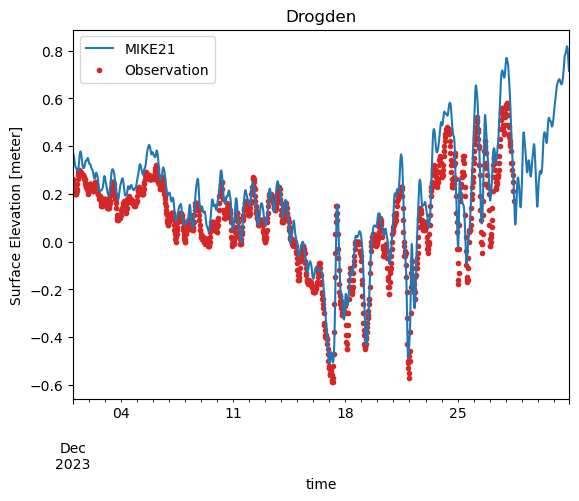

In [9]:
cc["Drogden"].sel(time=slice("2023-12-01","2023-12-31")).plot.timeseries();

## Scatter plots

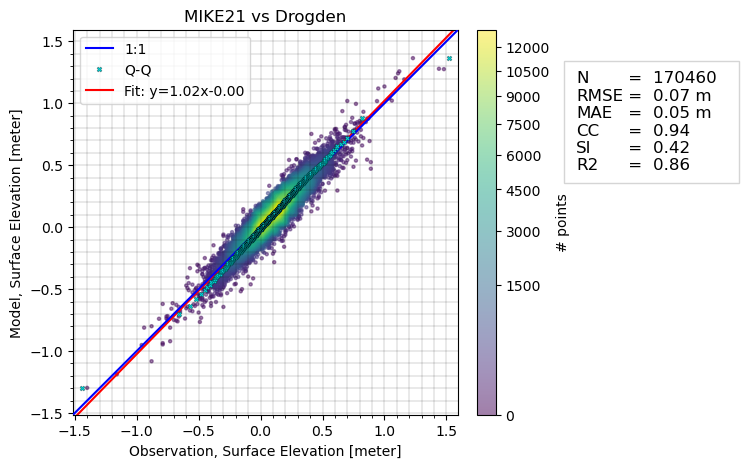

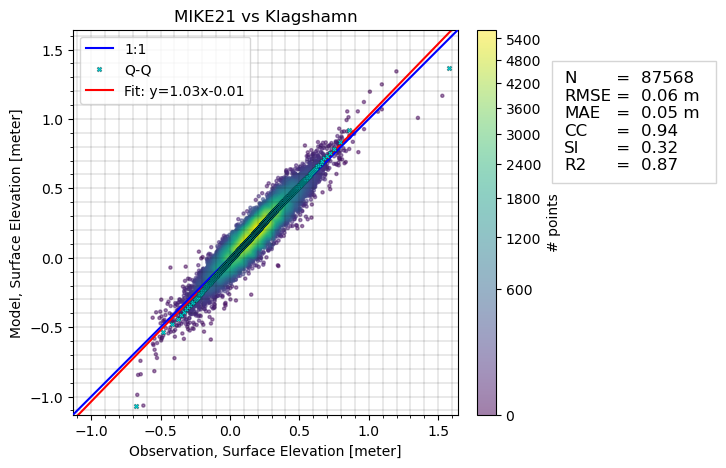

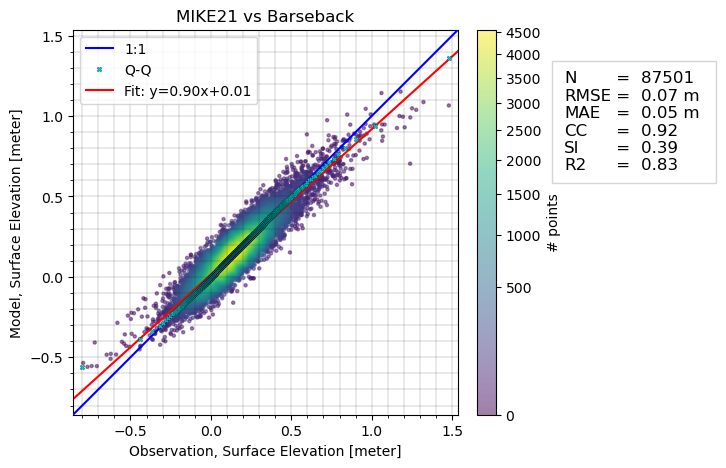

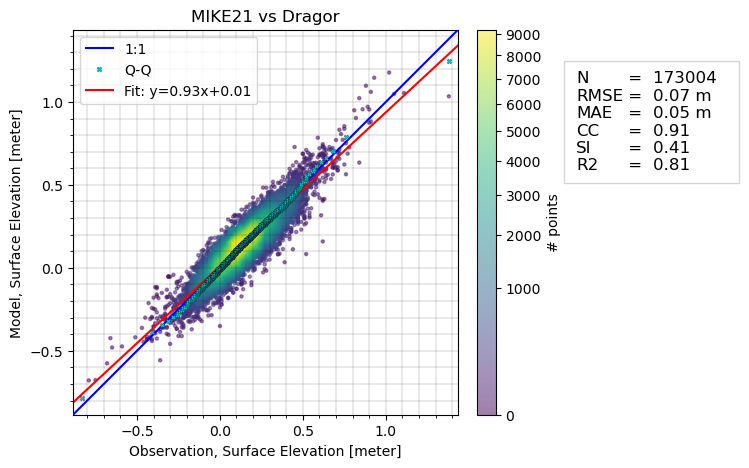

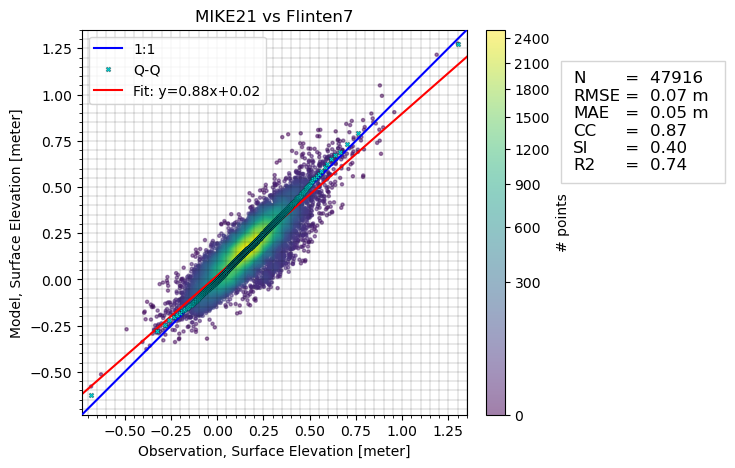

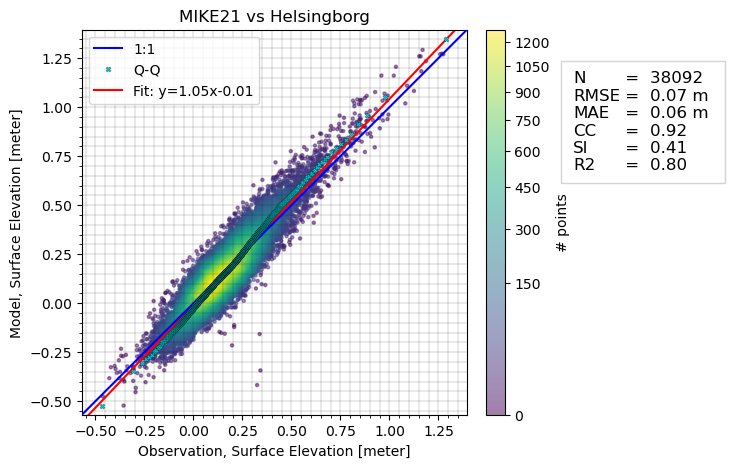

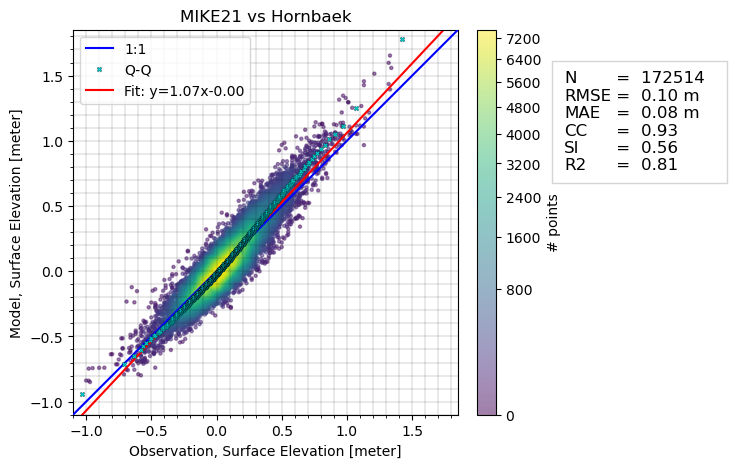

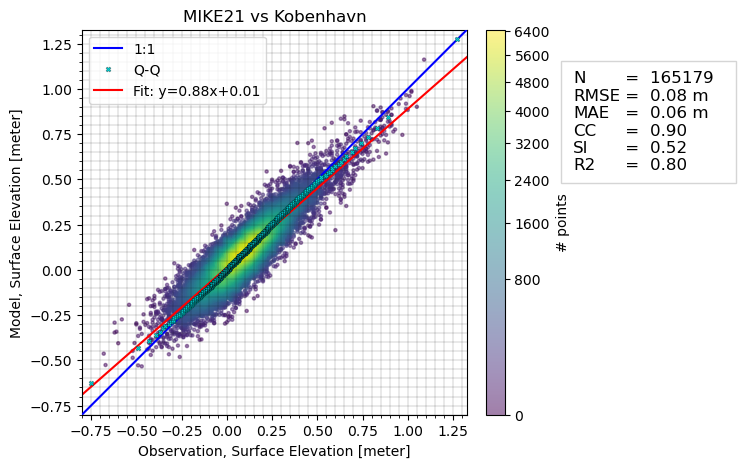

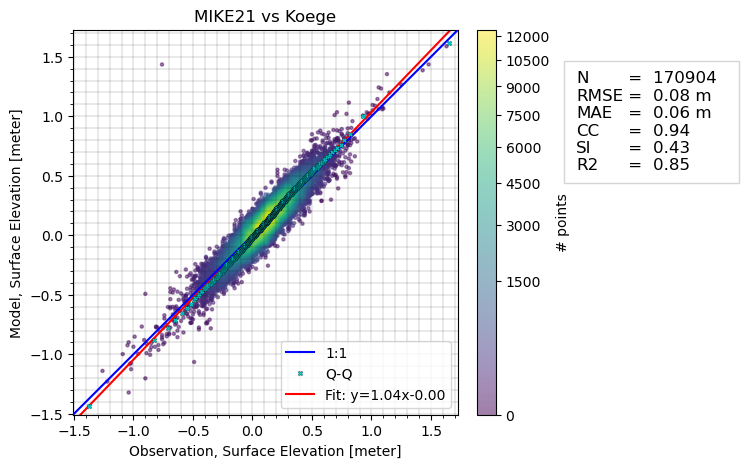

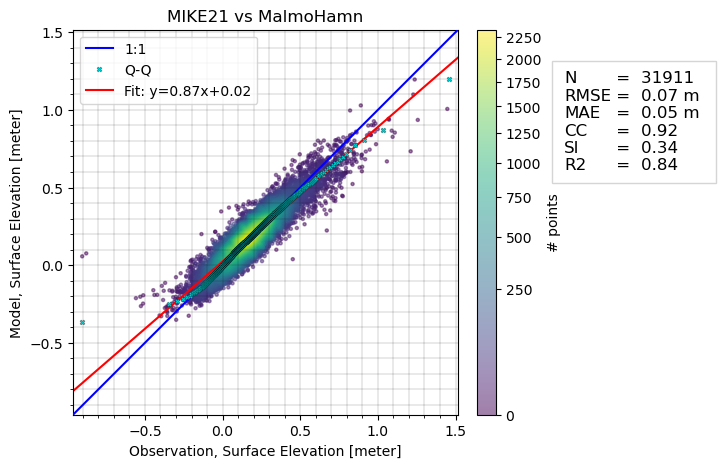

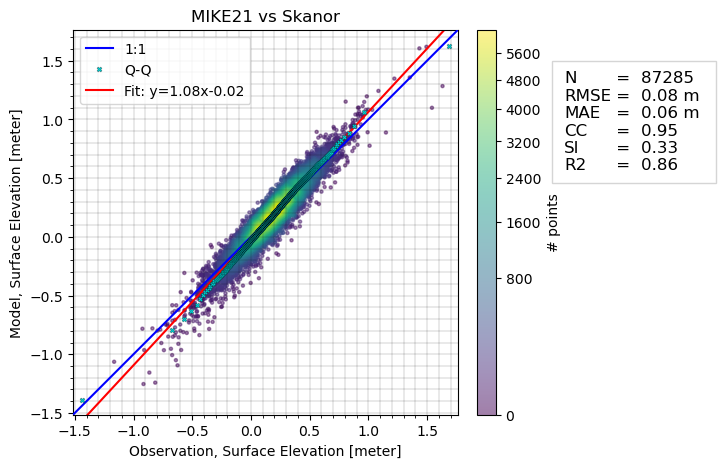

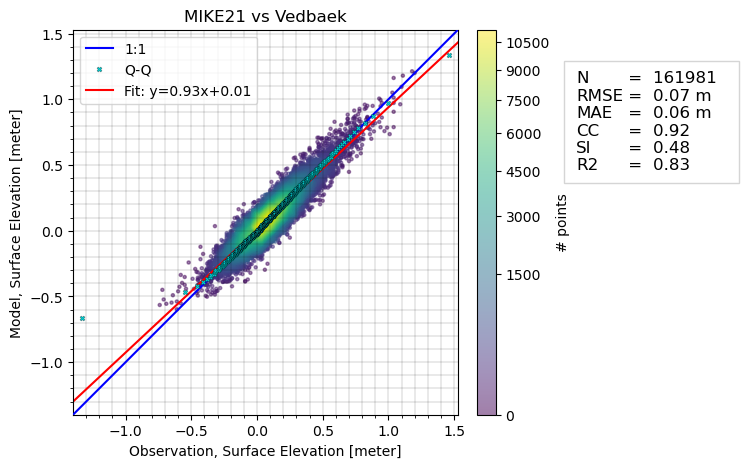

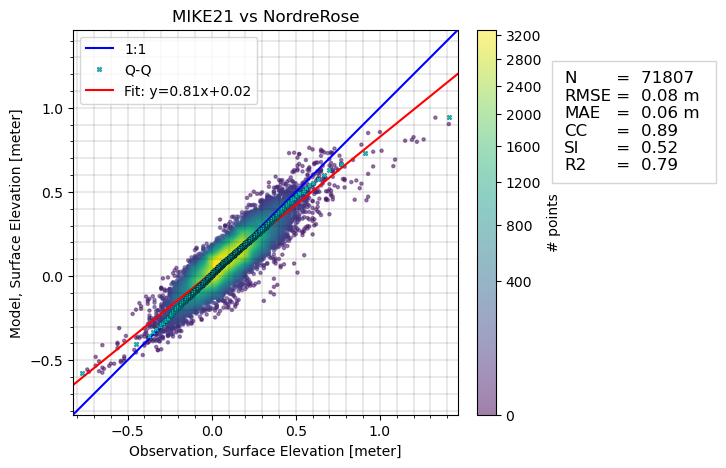

In [10]:
n_points_shown = 20000
for cmp in cc:
    cmp.plot.scatter(skill_table=True, show_points=n_points_shown, figsize=(6,5), bins=40);
    if save_png:
        plt.savefig(f"{fig_fldr}modelskill_comparison_{cmp.name}.png", bbox_inches='tight');